In [1]:
import wandb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull
from matplotlib.colors import Normalize  
from matplotlib.colors import LogNorm  
from matplotlib.ticker import FormatStrFormatter, LogFormatter  

api = wandb.Api(timeout=300)
runs = api.runs('microsoft-research-incubation/ds_mfmpre')

In [2]:
def linear_fit(xs, ys):
    # xs, ys may each be a Python list or 1d numpy array of x and y values
    model = LinearRegression()
    model.fit(np.array(xs).reshape(-1, 1), np.array(ys).reshape(-1, 1))
    slope, intercept = model.coef_[0][0], model.intercept_[0]
    return slope, intercept

In [3]:
run_list = [
            # "bfm650m_data3_maskspan3_ddp4e5d16mask020drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2", 
            "bfm3B_data2_maskspan3_ddp2e5d16mask030drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2", 
            "scalinglaw5m", "scalinglaw10m", "scalinglaw50m", "scalinglaw100m"]

run_params = {
    "bfm650m_data3_maskspan3_ddp4e5d16mask020drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2": 674973473,
    "bfm650m_data3_maskspan3_ddp4e5d16mask020drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2_2": 674973473,
    "bfm3B_data2_maskspan3_ddp2e5d16mask030drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2": 2890135076,
    "scalinglaw5m": 6186754,
    "scalinglaw10m": 36801538,
    "scalinglaw50m": 57807878,
    "scalinglaw100m": 120790028,
}

legend_names = {
    "bfm650m_data3_maskspan3_ddp4e5d16mask020drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2": 'bfm650M',
    "bfm650m_data3_maskspan3_ddp4e5d16mask020drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2_2": 'bfm650M',
    "bfm3B_data2_maskspan3_ddp2e5d16mask030drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2": 'bfm3B',
    "scalinglaw5m": 'bfm6M',
    "scalinglaw10m": 'bfm37M',
    "scalinglaw50m": 'bfm58M',
    "scalinglaw100m": 'bfm121M',
}

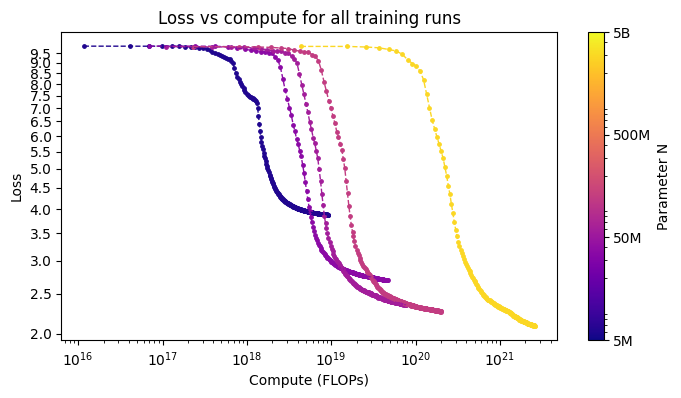

In [4]:
# plot validation loss vs compute for all runs 
run_occ = {}
loss_v_C_runs = []
for run in runs:
    if run.name not in run_list:
        continue

    loss_v_C_runs.append(run)

    # if run.name not in run_occ:
    #     run_occ[run.name] = 1
    # else:
    #     run_occ[run.name] = run_occ[run.name] + 1

# sort runs by run_params
loss_v_C_runs = sorted(loss_v_C_runs, key=lambda run: run_params[run.name])

# Prepare lists for plotting  
compute_values = []  
loss_values = []  
param_values = []  # List to store the parameter value for color mapping  


loss_v_C = {}

for run in loss_v_C_runs:  
    N = run_params[run.name]  
    D = 6000000  
    tokens_per_iter = 1024 * 1536  
    run_history = [row for row in run.scan_history()]  
      
    global_step = []  
    losses = []
    intervel = 5
    idx = 0
    for step in run_history[1:]:  
        if 'train_inner/global_step' in step and 'train_inner/loss' in step and idx % intervel == 0:
            s = step['train_inner/global_step']
            if s is not None:
                global_step.append(step['train_inner/global_step'])
                losses.append(step['train_inner/loss_bpe'])
        
        idx = idx + 1
    
    
    if run.name == "bfm3B_data2_maskspan3_ddp2e5d16mask030drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2":
        compute = []
        for step in global_step:
            if step is None:
                compute.append(0)
            else:
                compute.append(6 * N * step * 0.8 * tokens_per_iter)
    elif run.name == "bfm650m_data3_maskspan3_ddp4e5d16mask020drop1L1536B2k_bpev2pairv4_bert2_128A100_adam2":
        compute = []
        for step in global_step:
            if step is None:
                compute.append(0)
            else:
                compute.append(6 * N * step * 2 * tokens_per_iter)
    else:
        compute = [6 * N * step * tokens_per_iter for step in global_step]

    compute_values.append(compute)  
    loss_values.append(losses)  
    param_values.append([N] * len(compute))  # Use run parameter for color  

# Create a scatter plot with colors based on run_params
min_val = 5000000
max_val = 5000000000
norm = LogNorm(vmin=min_val, vmax=max_val)
cmap = plt.get_cmap('plasma')  

for idx in range(len(compute_values)):
    color = cmap(norm(param_values[idx][0]))
    plt.scatter(compute_values[idx], loss_values[idx], color=color, s=6)
    plt.plot(compute_values[idx], loss_values[idx], '--', linewidth=1, color=color)

sc = plt.scatter([], [], c=[], cmap='plasma', norm=norm)  

# Add a color bar with a label  
cbar = plt.colorbar(sc, norm=norm)  
cbar.set_label('Parameter N')  
cbar_ticks = [min_val, min_val*10, min_val*100, max_val]  
cbar.set_ticks(cbar_ticks)  
cbar.set_ticklabels(['5M', '50M', '500M', '5B'])  

plt.xscale("log")  
plt.yscale("log")  
plt.xlabel("Compute (FLOPs)")  
plt.ylabel("Loss")  
plt.yticks(np.arange(2.0, 10.0, 0.5))  
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  
plt.title("Loss vs compute for all training runs")  


# save plot with size 1280x960
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 4)
fig.savefig('./bfm_scalinglaw.png', dpi=300)

# 
# {'train_inner/SamplePerSec': 618.5223999023438, 'train_inner/total_acc_sample': 204800, '_step': 1, 'train_inner/batch': 200, 'train_inner/total_samples': 12800, 'train_inner/epoch': 0, '_runtime': 737.9245097637177, 'train_inner/mlm_acc': 0.028053624629974364, 'train_inner/total_loss': 10.3392333984375, 'train_inner/bpe_acc': 0.00011197470128536224, 'train_inner/loss_type': 7.093716430664062, 'train_inner/loss_mlm': 3.6306381225585938, 'train_inner/loss': 10.339072408676147, 'train_inner/lr': 2.6533333333333333e-07, 'train_inner/loss_bpe': 9.870330810546875, '_timestamp': 1706400623.4756377, 'train_inner/type_acc': 0.0010210137069225312, 'train_inner/global_step': 200, 'train_inner/grad_scale': 1}
